# IMDb vélemények hangulatelemzése

Az alábbi notebook hangulatelemzést használ az IMDb filmkritikák osztályozására statikus (GloVe) és kontextuális (BERT) beágyazások alkalmazásával.
A cél az, hogy értékeljük a hatékonyságukat az érzelmek osztályozásában, betekintést nyújtva a modellválasztás és alkalmazási stratégiák terén a természetes nyelvfeldolgozás feladataiban.

### 1. Projekt felállítása

#### Adatkészlet megszerzése

Először is, importáljuk az adatkészletet egy nyilvános github repóból, amelyből majd a modelljeinket tanítani fogjuk.

In [ ]:
! rm -rf * && wget https://raw.githubusercontent.com/SereMark/Sentiment-Analysis/main/IMDB%20Dataset.csv

--2024-06-02 19:44:00--  https://raw.githubusercontent.com/SereMark/Sentiment-Analysis/main/IMDB%20Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66212309 (63M) [text/plain]
Saving to: ‘IMDB Dataset.csv’

IMDB Dataset.csv    100%[===================>]  63.14M   245MB/s    in 0.3s    

2024-06-02 19:44:01 (245 MB/s) - ‘IMDB Dataset.csv’ saved [66212309/66212309]



#### Könyvtárak importálása

Ezután importáljuk az összes szükséges könyvtárat és keretrendszert.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torchtext; torchtext.disable_torchtext_deprecation_warning()
import torchtext.vocab as vocab
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from tqdm import tqdm
import warnings

Konkrét figyelmeztetések elnyomása a tiszta kimenet érdekében, különösen azokat, amelyek nem relevánsak a végrehajtás szempontjából, mint a fordítási részletek és az elavulási figyelmeztetések, amelyek nem befolyásolják a modell teljesítményét.

In [ ]:
warnings.filterwarnings("ignore", message="1Torch was not compiled with flash attention.")

A számítási eszköz GPU-ra állítása, ha elérhető, gyorsabb feldolgozás érdekében, egyébként CPU használata. Ez a választás kulcsfontosságú, mivel a BERT és más mélytanulási modellek számításigényesek és jelentősen profitálhatnak a GPU gyorsításból.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Adatkészlet betöltése és előfeldolgozása

Az összes véleményt kisbetűssé alakítjuk az egységesítés érdekében, és a hangulatokat bináris értékekre térképezzük az osztályozáshoz.

In [ ]:
imdb_data = pd.read_csv('IMDB Dataset.csv')
imdb_data['review'] = imdb_data['review'].str.lower()  # Szöveg normalizálása kisbetűsítéssel.
imdb_data['sentiment'] = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})  # Szöveges hangulatcímkék bináris értékké térképezése.

Az adatkészletet betanító és validáló halmazra bontjuk 80/20 arányban. Ez segít a modell validálásában láthatatlan adatokon. A véletlenszerű állapot rögzítve van a 42-es értéken az osztás reprodukálhatóságának biztosítása érdekében.

In [ ]:
train_reviews, val_reviews, train_sentiments, val_sentiments = train_test_split(
    imdb_data['review'].tolist(), imdb_data['sentiment'].tolist(), test_size=0.2, random_state=42
)

#### Véleményhosszak hisztogramjának ábrázolása az egyes hangulatok szerint

Vélemények különválasztása hangulat alapján a pozitív és negatív vélemények szavainak számának megértéséhez.

In [ ]:
positive_reviews = [len(review.split()) for review, sentiment in zip(imdb_data['review'].tolist(), imdb_data['sentiment'].tolist()) if sentiment == 1]
negative_reviews = [len(review.split()) for review, sentiment in zip(imdb_data['review'].tolist(), imdb_data['sentiment'].tolist()) if sentiment == 0]

Véleményhosszak hisztogramjának ábrázolása, mely segít megérteni, hogy a vélemények hossza összefügg-e a hangulattal, ami befolyásolhatja a modell betanítását.

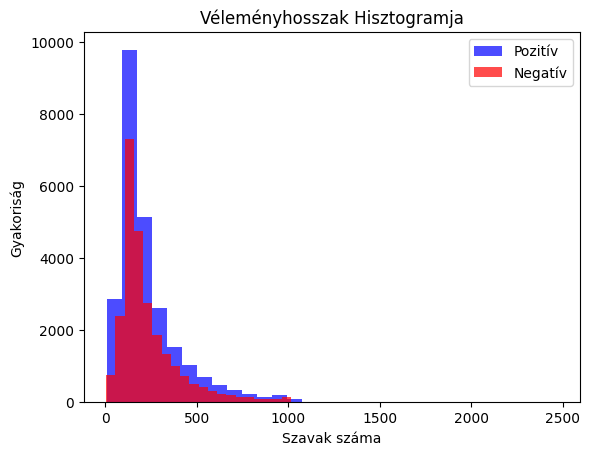

In [ ]:
plt.figure()
plt.hist(positive_reviews, bins=30, color='blue', alpha=0.7, label='Pozitív')
plt.hist(negative_reviews, bins=30, color='red', alpha=0.7, label='Negatív')
plt.title('Véleményhosszak Hisztogramja')
plt.xlabel('Szavak száma')
plt.ylabel('Gyakoriság')
plt.legend(loc='upper right')
plt.show()

### 2. Modellek és osztályok felállítása

#### GloVe

##### GloVe beágyazások inicializálása

Itt a GloVe-t használjuk statikus szóbeágyazási módszerként a szavak alacsony dimenziós vektortérben való reprezentálására. Ez a modell előre betanított, és egy korpuszban a szavak együttes előfordulása alapján rögzíti a szemantikai jelentést.

In [ ]:
glove_embeddings = vocab.GloVe(name='6B', dim=100)  # 100 dimenziós tér használata minden szó reprezentálására.

.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17950.33it/s]


##### Függvény a GloVe beágyazások lekérésére szövegből

Ez a függvény tokenizálja a szöveget, lekéri a tokenek beágyazásait, ha elérhetőek, és átlagolja őket egy fix hosszúságú bemeneti vektor létrehozásához a neurális hálózat számára. Ez az átlagos beágyazás egyszerű, de hatékony módszer a szöveginformáció kódolására.

In [ ]:
def fetch_glove_embeddings(text):
    tokens = text.split()
    embeddings = [glove_embeddings[t].unsqueeze(0) for t in tokens if t in glove_embeddings.stoi]
    return torch.cat(embeddings, dim=0).mean(dim=0) if embeddings else torch.zeros(glove_embeddings.dim)

train_glove_embeddings = [fetch_glove_embeddings(text) for text in train_reviews]
val_glove_embeddings = [fetch_glove_embeddings(text) for text in val_reviews]

##### GloVe beágyazásokat használó adatkészlet osztály

Ez a saját adatkészlet előkészíti az előre kiszámított GloVe beágyazásokból álló kötegeket, amelyeket egy egyszerű neurális hálózati osztályozó betanítására használunk. Ez az osztály kapszulázza az adatkezelést a PyTorch modell betanításához.

In [ ]:
class GloVeDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.stack(embeddings)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {'embedding': self.embeddings[idx].clone().detach(), 'label': self.labels[idx]}

#### BERT

##### BERT tokenizáló és modell beállítása

A BERT egy specifikus szövegelőfeldolgozási típust igényel egy tokenizálóval, ami szétbontja a szöveget tokenekre és leképezi őket az előre betanított modell szókincsének megfelelő indexekre.

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

##### BERT tokenizált adatokat használó adatkészlet osztály

Hasonló a GloVe adatkészlethez, de a BERT bemenetekre szabva. Feldolgozza a szöveget a BERT tokenizálójával, automatikusan kezeli a maximális hosszt és a kitöltést, és előkészíti a bemeneti tenzorokat a BERT modell feldolgozásához.

In [ ]:
class BertDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokenized_data = bert_tokenizer(
            self.texts[idx], padding='max_length', truncation=True, max_length=256, return_tensors="pt"
        )
        return {
            'input_ids': tokenized_data['input_ids'].squeeze().clone().detach(),
            'attention_mask': tokenized_data['attention_mask'].squeeze().clone().detach(),
            'labels': self.labels[idx]
        }

#### Általánosított modell osztály az érzelmek elemzéséhez

Ez az osztály egy BERT-alapú osztályozó és egy egyszerűbb neurális háló között tud válogatni a 'model_type' paraméter alapján. Ez a polimorfizmus demonstrációja a modelltervezésben PyTorch keretrendszeren belül.

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, model_type='BERT'):
        super().__init__()
        if model_type == 'BERT':
            self.model = BertModel.from_pretrained('bert-base-uncased')
            self.dropout = nn.Dropout(0.3)  # Dropout a szabályozásra.
            self.classifier = nn.Linear(self.model.config.hidden_size, 2)  # A végső kimeneti réteg, ami a BERT kimeneteket két osztályra képezi le.
        else:
            self.fc1 = nn.Linear(100, 50)  # Az egyszerű neurális háló első rétege a GloVe beágyazásokhoz.
            self.relu = nn.ReLU()  # ReLU aktivációs függvény a nemlinearitás bevezetésére.
            self.dropout = nn.Dropout(0.5)  # Magasabb dropout arány az egyszerűbb modelleknél a túltanulás elkerülése érdekében.
            self.fc2 = nn.Linear(50, 2)  # A végső réteg, ami két osztályra képezi le a kimeneteket.

    def forward(self, x, attention_mask=None):
        if hasattr(self, 'model'):
            output = self.model(x, attention_mask=attention_mask)[1]  # Feldolgozza a bemenetet a BERT modellen keresztül.
            output = self.dropout(output)
            return self.classifier(output)  # Alkalmazza az osztályozót a BERT kimenetére.
        else:
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
            return self.fc2(x)  # Feldolgozza a bemenetet az egyszerű neurális hálón keresztül.

#### Felkészülés a tanításra

##### Adatok betöltése DataLoaderbe

A DataLoader-ek kulcsfontosságú összetevők a PyTorchban az adatok kötegelt kezelésére. Automatizálják az adatok betöltését és keverését, iterálhatóvá téve az adatkészletet a betanítási és értékelési fázisok során.

In [ ]:
train_loader = DataLoader(BertDataset(train_reviews, train_sentiments), batch_size=16, shuffle=True)
val_loader = DataLoader(BertDataset(val_reviews, val_sentiments), batch_size=16, shuffle=False)
glove_train_loader = DataLoader(GloVeDataset(train_glove_embeddings, train_sentiments), batch_size=16, shuffle=True)
glove_val_loader = DataLoader(GloVeDataset(val_glove_embeddings, val_sentiments), batch_size=16, shuffle=False)

##### Modellek, optimalizálók és veszteségfüggvény inicializálása

Az optimalizáló választása és beállításai, mint a tanulási ráta, jelentősen befolyásolhatják a betanítási dinamikát és a modellek végső teljesítményét. Itt az Adam optimalizálót használjuk, mivel hatékonyan kezeli a ritka gradienseket és adaptív tanulási rátát biztosít.

In [ ]:
bert_classifier = SentimentClassifier('BERT').to(device)  # BERT-alapú modell inicializálása és GPU-ra helyezése, ha elérhető.
glove_classifier = SentimentClassifier('GloVe').to(device)  # GloVe-alapú egyszerű neurális háló modell szintén GPU-ra helyezése.
optimizer_bert = torch.optim.Adam(bert_classifier.parameters(), lr=2e-5)  # Az BERT tanulási rátája nagyon alacsony kell legyen a túltanulás elkerülése érdekében.
optimizer_glove = torch.optim.Adam(glove_classifier.parameters(), lr=5e-4)  # Magasabb tanulási ráta az egyszerűbb modellhez.
loss_function = nn.CrossEntropyLoss()  # A CrossEntropyLoss alkalmas bináris osztályozási feladatokra.

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### 3. Betanítás

#### Betanítási függvény

A betanítási függvény kapszulázza a betanítási ciklust, amely többször ismétlődik az adatkészleten (epochok), feldolgozva minden köteget, kiszámítva a veszteséget, és frissítve a modell súlyait. Kiírja a betanítási előrehaladást és a veszteséget minden epochnál, betekintést nyújtva abba, hogy milyen jól tanul a modell.

In [ ]:
def train(model, loader, optimizer, loss_function, device, model_type='BERT', epochs=1):
    model.train()  # A modellt betanítási módba állítja.
    all_epoch_losses = []  # Lista a veszteségek tárolására epochonként későbbi elemzéshez.
    print("A betanítás elkezdődött...")
    for epoch in range(epochs):  # Többször ismételjük meg az adatkészletet.
        epoch_loss = 0
        print(f"Epoch {epoch+1}/{epochs} elkezdődött...")
        for batch in tqdm(loader, desc=f"{epoch+1}. Epoch betanítása"):  # tqdm használata a haladás megjelenítésére minden epochnál.
            optimizer.zero_grad()  # Régi gradiensek törlése az utolsó lépésből.
            if model_type == 'BERT':
                input_ids = batch['input_ids'].to(device)  # Kötegadatok betöltése a GPU-ra.
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)  # Köteg átadása a modellen.
            else:
                embeddings = batch['embedding'].to(device)
                labels = batch['label'].to(device)
                outputs = model(embeddings)
            loss = loss_function(outputs, labels)  # Veszteség kiszámítása a modell kimenete és a tényleges címkék között.
            loss.backward()  # Visszaterjedési lépés a gradiensek kiszámításához.
            optimizer.step()  # Súlyok módosítása a gradiensek alapján.
            epoch_loss += loss.item()  # A veszteség összegzése jelentéshez.
        avg_loss = epoch_loss / len(loader)  # Az epoch átlagos vesztése.
        all_epoch_losses.append(avg_loss)  # Az átlagos veszteség tárolása.
        print(f"{epoch+1}. Epoch betanítása befejeződött. Betanítási veszteség: {avg_loss}")
    print("A betanítás befejeződött.")
    return all_epoch_losses  # Visszaadja az egyes epochok átlagos veszteségét az elemzéshez.


#### Mindkét modell betanítása

A modelleket bizonyos számú epochokon keresztül betanítjuk.

In [ ]:
bert_losses = train(bert_classifier, train_loader, optimizer_bert, loss_function, device, 'BERT', epochs=3)
glove_losses = train(glove_classifier, glove_train_loader, optimizer_glove, loss_function, device, 'GloVe', epochs=3)

A betanítás elkezdődött...
Epoch 1/3 elkezdődött...


1. Epoch betanítása: 100%|██████████| 2500/2500 [32:40<00:00,  1.28it/s]


1. Epoch betanítása befejeződött. Betanítási veszteség: 0.24643469770625234
Epoch 2/3 elkezdődött...


2. Epoch betanítása: 100%|██████████| 2500/2500 [32:44<00:00,  1.27it/s]


2. Epoch betanítása befejeződött. Betanítási veszteség: 0.1337732559967786
Epoch 3/3 elkezdődött...


3. Epoch betanítása: 100%|██████████| 2500/2500 [32:43<00:00,  1.27it/s]


3. Epoch betanítása befejeződött. Betanítási veszteség: 0.0693017502032686
A betanítás befejeződött.
A betanítás elkezdődött...
Epoch 1/3 elkezdődött...


1. Epoch betanítása: 100%|██████████| 2500/2500 [00:04<00:00, 584.73it/s]


1. Epoch betanítása befejeződött. Betanítási veszteség: 0.6006327442526818
Epoch 2/3 elkezdődött...


2. Epoch betanítása: 100%|██████████| 2500/2500 [00:04<00:00, 517.88it/s]


2. Epoch betanítása befejeződött. Betanítási veszteség: 0.524588534861803
Epoch 3/3 elkezdődött...


3. Epoch betanítása: 100%|██████████| 2500/2500 [00:05<00:00, 469.13it/s]

3. Epoch betanítása befejeződött. Betanítási veszteség: 0.5050698356926441
A betanítás befejeződött.


### 4. Értékelés

#### Értékelési függvény

Ez a függvény értékeli a betanított modellt egy validációs készleten. Kikapcsolja a gradiensszámítást, ezzel memóriát takarít meg és gyorsítja fel a számítást, ami létfontosságú a nagy modellek, mint a BERT értékelésekor. Kiszámítja a modell predikcióit, összehasonlítja azokat a valódi címkékkel, és kiszámítja a pozitív hangulat valószínűségét, amely hasznos az ROC és a precizitás-visszahívás görbék elemzéséhez.

In [ ]:
def evaluate(model, loader, device, model_type='BERT'):
    model.eval()  # A modellt értékelési módba állítja.
    predictions, true_labels, probabilities = [], [], []
    print("Az értékelés elkezdődött...")
    with torch.no_grad():  # Gradiensszámítás kikapcsolása a memória megtakarítása és a számítás gyorsítása érdekében.
        for batch in tqdm(loader, desc="Értékelés"):  # Iterálás minden egyes kötegen a betöltőn keresztül.
            if model_type == 'BERT':
                input_ids = batch['input_ids'].to(device)  # Kötegadatok betöltése a GPU-ra.
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)  # Adatok átadása a modellen.
                outputs = outputs.softmax(dim=-1)  # Softmax alkalmazása a valószínűségek megszerzéséhez.
            else:
                embeddings = batch['embedding'].to(device)
                labels = batch['label'].to(device)
                outputs = model(embeddings)
                outputs = outputs.softmax(dim=-1)
            _, preds = torch.max(outputs, dim=1)  # A prediktált címkék megszerzése.
            predictions.extend(preds.cpu().numpy())  # Predikciók tárolása a metrikák kiszámításához később.
            true_labels.extend(labels.cpu().numpy())  # Valódi címkék tárolása a metrikák kiszámításához.
            probabilities.extend(outputs.cpu().numpy()[:, 1])  # Valószínűségek tárolása az ROC és a precizitás-visszahívás elemzéshez.
    print("Az értékelés befejeződött.")
    print(classification_report(true_labels, predictions))  # A modell teljesítményének értékelésére szolgáló osztályozási metrikák kiírása.
    return predictions, true_labels, probabilities  # Visszaadja a predikciókat, a valódi címkéket és a valószínűségeket további elemzéshez.

#### Mindkét modell értékelése

A betanítás után mindkét modellt értékeljük a validációs készleten az objektív teljesítmény összehasonlításához.

In [ ]:
bert_preds, bert_labels, bert_probs = evaluate(bert_classifier, val_loader, device, 'BERT')
glove_preds, glove_labels, glove_probs = evaluate(glove_classifier, glove_val_loader, device, 'GloVe')

Az értékelés elkezdődött...


Értékelés: 100%|██████████| 625/625 [03:15<00:00,  3.19it/s]


Az értékelés befejeződött.
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4961
           1       0.92      0.94      0.93      5039

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Az értékelés elkezdődött...


Értékelés: 100%|██████████| 625/625 [00:00<00:00, 1498.82it/s]

Az értékelés befejeződött.
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      4961
           1       0.77      0.77      0.77      5039

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



### 5. Ábrázolás
Modelljeinket grafikonok segítségével tudjuk összehasonlítani

#### Betanítási veszteség összehasonlító ábrázolás

Ábrázoljuk a két modell betanítási veszteségeit az adott epochokon keresztül, hogy vizualizáljuk és összehasonlítsuk, hogy melyik modell hogyan tanul az idő múlásával. Egy alacsonyabb vagy simább veszteség görbe jobb tanulási folyamatot jelezhet.

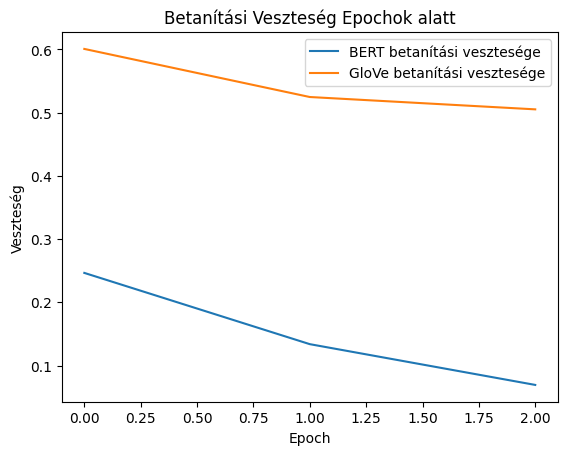

In [ ]:
def plot_combined_training_loss(losses1, losses2, name1, name2):
    plt.figure()
    plt.plot(losses1, label=f'{name1} betanítási vesztesége')  # BERT betanítási veszteségeinek ábrázolása.
    plt.plot(losses2, label=f'{name2} betanítási vesztesége')  # GloVe betanítási veszteségeinek ábrázolása.
    plt.xlabel('Epoch')
    plt.ylabel('Veszteség')
    plt.title('Betanítási Veszteség Epochok alatt')
    plt.legend()
    plt.show()

plot_combined_training_loss(bert_losses, glove_losses, 'BERT', 'GloVe')

#### Prediktált valószínűségek hisztogramjának összehasonlító ábrázolása

Az alábbi ábra betekintést nyújt a modellek bizonyosságába a predikcióikban, ami lényeges lehet az alkalmazásokban, ahol a bizonyossági küszöbök fontosak, illetve segít feltárni, hogy melyik modell hogyan különbözteti meg a kategóriákat.

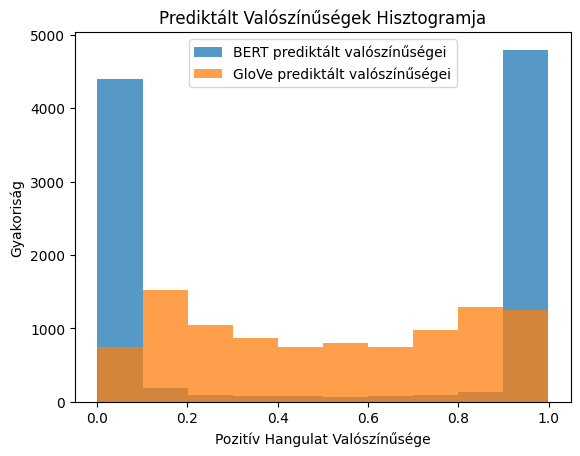

In [ ]:
def plot_combined_probability_histogram(probs1, probs2, name1, name2):
    plt.figure()
    plt.hist(probs1, bins=10, alpha=0.75, label=f'{name1} prediktált valószínűségei')  # BERT valószínűségek hisztogramja.
    plt.hist(probs2, bins=10, alpha=0.75, label=f'{name2} prediktált valószínűségei')  # GloVe valószínűségek hisztogramja.
    plt.title('Prediktált Valószínűségek Hisztogramja')
    plt.xlabel('Pozitív Hangulat Valószínűsége')
    plt.ylabel('Gyakoriság')
    plt.legend()
    plt.show()

plot_combined_probability_histogram(bert_probs, glove_probs, 'BERT', 'GloVe')

#### ROC görbe összehasonlítás

Ábrázoljuk a két modell Receiver Operating Characteristic (ROC) görbéit. Az ROC görbék hasznosak a bináris osztályozók diagnosztikai képességének értékelésére, ami alapvető a hangulat elemzési feladatokban. A görbe alatti terület (AUC) használható a modell teljesítményének összefoglalására, ahol az AUC közel 1.0 egy nagyon jó modellt jelent, és 0.5 egy olyan modellt, amelynek nincs megkülönböztető képessége.

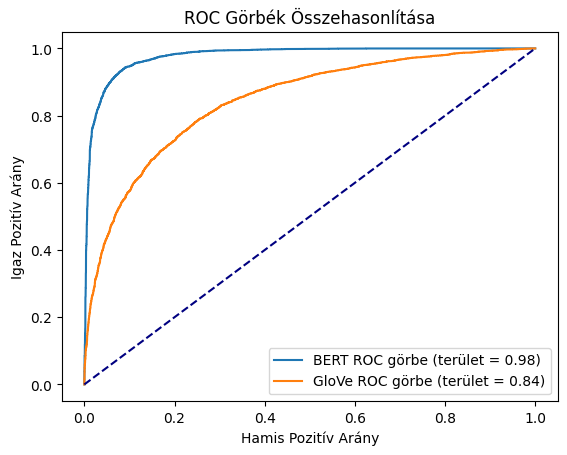

In [ ]:
def plot_combined_roc_curve(true_labels1, probs1, true_labels2, probs2, name1, name2):
    fpr1, tpr1, _ = roc_curve(true_labels1, probs1)  # Hamis pozitív arány és igaz pozitív arány számítása a BERT-hez.
    roc_auc1 = auc(fpr1, tpr1)  # A BERT ROC görbe alatti területének kiszámítása.
    fpr2, tpr2, _ = roc_curve(true_labels2, probs2)  # Hamis pozitív arány és igaz pozitív arány számítása a GloVe-hoz.
    roc_auc2 = auc(fpr2, tpr2)  # A GloVe ROC görbe alatti területének kiszámítása.

    plt.figure()
    plt.plot(fpr1, tpr1, label=f'{name1} ROC görbe (terület = {roc_auc1:.2f})')  # BERT ROC görbének ábrázolása.
    plt.plot(fpr2, tpr2, label=f'{name2} ROC görbe (terület = {roc_auc2:.2f})')  # GloVe ROC görbének ábrázolása.
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy')  # Referenciavonal ábrázolása.
    plt.xlabel('Hamis Pozitív Arány')
    plt.ylabel('Igaz Pozitív Arány')
    plt.title('ROC Görbék Összehasonlítása')
    plt.legend(loc="lower right")
    plt.show()

plot_combined_roc_curve(bert_labels, bert_probs, glove_labels, glove_probs, 'BERT', 'GloVe')

#### Konfúziós mátrix összehasonlítás

A konfúziós mátrix egy olyan táblázat, amely gyakran használatos egy osztályozási modell teljesítményének leírására egy olyan tesztadathalmazon, amelynek ismertek a valódi értékei. Lehetővé teszi az algoritmus teljesítményének vizualizációját.

Az alábbi ábra segít vizualizálni, hogy hol teljesítenek jól a modellek és hol hibáznak, betekintést nyújtva a lehetséges javításokba vagy beállításokba a modell betanításában vagy az előfeldolgozásban.

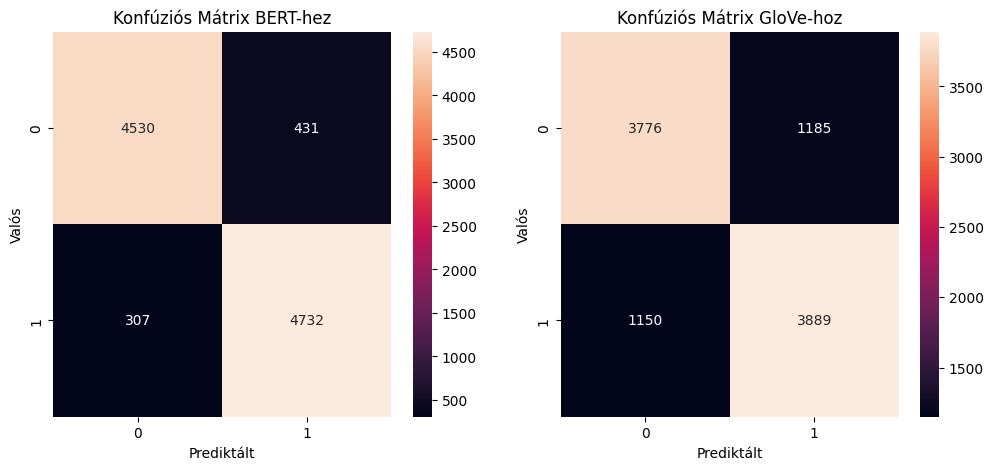

In [ ]:
def plot_combined_confusion_matrix(true_labels1, predictions1, true_labels2, predictions2, name1, name2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Ábra és alábrák létrehozása.

    cf_matrix1 = confusion_matrix(true_labels1, predictions1)  # BERT konfúziós mátrixának számítása.
    sns.heatmap(cf_matrix1, annot=True, fmt='g', ax=ax[0])  # BERT konfúziós mátrixának hőtérképes ábrázolása.
    ax[0].set_title(f'Konfúziós Mátrix {name1}-hez')  # Cím beállítása a BERT konfúziós mátrixához.
    ax[0].set_xlabel('Prediktált')  # X-tengely címke beállítása a BERT konfúziós mátrixához.
    ax[0].set_ylabel('Valós')  # Y-tengely címke beállítása a BERT konfúziós mátrixához.

    cf_matrix2 = confusion_matrix(true_labels2, predictions2)  # GloVe konfúziós mátrixának számítása.
    sns.heatmap(cf_matrix2, annot=True, fmt='g', ax=ax[1])  # GloVe konfúziós mátrixának hőtérképes ábrázolása.
    ax[1].set_title(f'Konfúziós Mátrix {name2}-hoz')  # Cím beállítása a GloVe konfúziós mátrixához.
    ax[1].set_xlabel('Prediktált')  # X-tengely címke beállítása a GloVe konfúziós mátrixához.
    ax[1].set_ylabel('Valós')  # Y-tengely címke beállítása a GloVe konfúziós mátrixához.

    plt.show()

plot_combined_confusion_matrix(bert_labels, bert_preds, glove_labels, glove_preds, 'BERT', 'GloVe')

#### Precizitás-visszahívás görbe összehasonlítás

A precizitás-visszahívás egy hasznos mérőszám a predikció sikerességére, amikor az osztályok nagyon egyenlőtlenül vannak elosztva. Magas terület a görbe alatt mind magas visszahívást, mind magas precizitást jelent, ahol a magas precizitás alacsony hamis pozitív arányt, a magas visszahívás pedig alacsony hamis negatív arányt jelent.

Ez az ábra betekintést nyújt a visszahívás és a precizitás közötti egyensúlyba mindkét modell esetében, segítve megérteni, hogy melyik modell teljesít jobban a precizitás és visszahívás egyensúlyának fenntartásában.

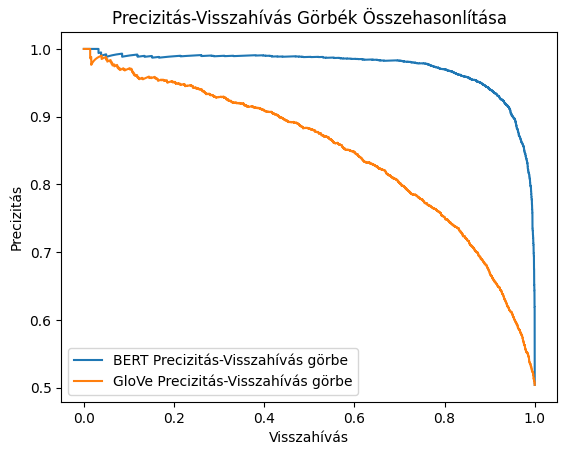

In [ ]:
def plot_combined_precision_recall_curve(true_labels1, probs1, true_labels2, probs2, name1, name2):
    precision1, recall1, _ = precision_recall_curve(true_labels1, probs1)  # Precizitás és visszahívás számítása a BERT-hez.
    precision2, recall2, _ = precision_recall_curve(true_labels2, probs2)  # Precizitás és visszahívás számítása a GloVe-hoz.

    plt.figure()
    plt.plot(recall1, precision1, label=f'{name1} Precizitás-Visszahívás görbe')  # BERT precizitás-visszahívás görbének ábrázolása.
    plt.plot(recall2, precision2, label=f'{name2} Precizitás-Visszahívás görbe')  # GloVe precizitás-visszahívás görbének ábrázolása.
    plt.xlabel('Visszahívás')
    plt.ylabel('Precizitás')
    plt.title('Precizitás-Visszahívás Görbék Összehasonlítása')
    plt.legend()
    plt.show()

plot_combined_precision_recall_curve(bert_labels, bert_probs, glove_labels, glove_probs, 'BERT', 'GloVe')

### 6. Tesztelés

#### Hangulat előrejelző függvény

Ez a függvény szövegbemenetet fogad és a megadott modell segítségével előrejelzi a hangulatot. Kezeli mind a BERT, mind a GloVe modelleket, a feldolgozást a modell típusa szerint módosítva. Ez a függvény kulcsfontosságú a betanított modellek termelési környezetben történő alkalmazásához vagy új adatokon való teszteléséhez.

In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    if not text.strip():
        return "Nincs bemenet", 0
    model.eval()  # Biztosítja, hogy a modell értékelési módban van, ami kikapcsolja a dropoutot és a köteg normalizációt.
    text = text.lower()  # A szöveg kisbetűsítése a betanítási adatok előfeldolgozásával való összhang érdekében.
    try:
        if tokenizer:
            tokenized = tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors="pt").to(device)  # A szöveg tokenizálása és a GPU-ra mozgatása, ha elérhető.
            with torch.no_grad():  # Gradiensszámítás kikapcsolása.
                output = model(tokenized['input_ids'], tokenized['attention_mask']).softmax(dim=-1)  # Modell predikcióinak megszerzése és softmax alkalmazása a valószínűségek konvertálásához.
        else:
            embeddings = fetch_glove_embeddings(text).unsqueeze(0).to(device)  # GloVe beágyazások lekérése és a GPU-ra mozgatása, ha elérhető.
            with torch.no_grad():  # Gradiensszámítás kikapcsolása.
                output = model(embeddings).softmax(dim=-1)  # Modell predikcióinak megszerzése és softmax alkalmazása a valószínűségek konvertálásához.
        pred = torch.argmax(output, dim=1).item()  # A prediktált osztály (0 vagy 1) megszerzése.
        certainty = output[0, pred].item()  # A prediktált osztályhoz tartozó valószínűség megszerzése.
        sentiment = 'Pozitív' if pred == 1 else 'Negatív'
        return sentiment, certainty * 100  # Visszaadja a hangulatot és a bizonyosságot százalékban.
    except Exception as e:
        return f"Hiba: {str(e)}", 0

#### Hangulat előrejelző widget

Ez a widget minden szövegváltozás esetén frissíti az előrejelzéseket, lehetővé téve a modellek interaktív módon való tesztelését.

In [ ]:
def update_output(change):
    text_input = change.new  # Az új szöveget kapja meg a widgetből.
    if text_input:  # Csak akkor frissít, ha a szöveg nem üres.
        bert_sentiment, bert_certainty = predict_sentiment(text_input, bert_classifier, bert_tokenizer, device)  # Hangulat előrejelzése BERT használatával.
        glove_sentiment, glove_certainty = predict_sentiment(text_input, glove_classifier, None, device)  # Hangulat előrejelzése GloVe használatával.
        with output:
            clear_output(wait=True)  # Az előző kimenet törlése.
            print(f"BERT: Hangulat - {bert_sentiment}, Bizonyosság - {bert_certainty:.2f}%")  # BERT előrejelzések megjelenítése.
            print(f"GloVe: Hangulat - {glove_sentiment}, Bizonyosság - {glove_certainty:.2f}%")  # GloVe előrejelzések megjelenítése.

#### Widget létrehozása

Ez a szakasz állítja be az interaktív widgetet a hangulat előrejelzéshez. Tartalmaz egy szövegbeviteli mezőt és egy kimeneti területet, ahol megjelennek az előrejelzések.

In [ ]:
text_input = widgets.Text(placeholder='Írjon valamit ide...', description='Bemenet:', disabled=False)  # Szövegbeviteli widget létrehozása.
output = widgets.Output()  # Kimeneti widget létrehozása az előrejelzések megjelenítésére.
text_input.observe(update_output, names='value')  # Megfigyelő beállítása, hogy hívja meg az update_output függvényt, amikor a szöveg megváltozik.
display(text_input, output)  # A widgetek megjelenítése.

Text(value='', description='Bemenet:', placeholder='Írjon valamit ide...')

Output()